# Clustering via Evolution of the Heat Equation

Clustering with the heat equation uses low eigenvectors of a graph Laplacian as indicator functions to extract clusters from a graph. These eigenvectors are analogous to low frequency Fourier modes and by selecting these modes we seek the Fourier basis functions of the discrete domain induced by the graph. 

Description of the experiment:
1. Create a circle graph with $n=100$ nodes
2. At the end nodes and middle nodes, set an edge weight to $0.001$
3. Initialize a random initial condition by sampling uniformly from $[0, 1]$.
4. Update the heat using forward Euler method for $T_{\text{max}} = 10000$ iterations
5. At each time $t'$, compute the *centered normalized* heat: $ \frac{u(t', n) - \texttt{AVG}[u(t', \bullet)]}{\|u(t', n) - \texttt{AVG}[u(t', \bullet)]\|}$

Hypothesis: the centered normalized heat converges to the second Eigenvector of the (symmetric) graph laplacian. 

Why? The function $u(t', n)$ is a superposition of eigenvectors whose coefficients decay exponentially in time. Subtracting the mean removes the first eigenvector so that the second should dominate the mixture.

**Generate a line graph**

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import gif
from lib.spectral_clustering import laplacian_matrix

# parameters
n = 100
dx = 1/n
dt = 0.001 * (1/2) * (dx**2) # Using CFL Conditions
T_max = 1000000

line_graph_similarity = np.diag(np.ones(n-1), k=1) + np.diag(np.ones(n-1), k=-1)

h = int(np.floor(n/2))
bad_edge_weight = 0.01
line_graph_similarity[h, h+1] = bad_edge_weight
line_graph_similarity[h+1, h] = bad_edge_weight
line_graph_similarity[0, -1] = bad_edge_weight
line_graph_similarity[-1, 0] = bad_edge_weight

laplacian, deg = laplacian_matrix(line_graph_similarity)



**Randomly initialize a function on the graph and step it in time**

In [49]:
evolution = np.zeros((n, T_max))

evolution[:, 0] = np.random.normal(scale=3, size=(n,)) 

c=0.001
for i in range(1, T_max):
    evolution[:, i:i+1] = evolution[:, i-1:i] - (dt / (dx)**2) * laplacian @ evolution[:, i-1:i] + c

In [50]:
@gif.frame
def plot_evec(i):
    sig = evolution[:, i] - np.mean(evolution[:, i])
    sig /= np.linalg.norm(sig)
    plt.plot(sig)
    plt.title("Centered Heat Diffusion on Disconnected Line Graph")
    plt.xlabel("Node")
    plt.ylabel("Heat")
    plt.ylim((-0.5, 0.5))
@gif.frame
def plot_time(i):
    sig = evolution[:, i]
    sig /= np.linalg.norm(sig)
    plt.plot(sig)
    plt.title("Centered Heat Diffusion on Disconnected Line Graph")
    plt.xlabel("Node")
    plt.ylabel("Heat")
    plt.ylim((-0.5, 0.5))
frames_noscale = []
b = 2
for i in np.logspace(np.log10(1)/np.log10(b), np.log10(T_max)/np.log10(b), base=b):
    if(i < T_max):
        frames_noscale.append(plot_time(int(i)))
gif.save(frames_noscale, "Diffusion_L_0.001_c.gif", duration=100)

When starting with heat sampled from $[0, 1]$

![](Diffusion_L_0.001_c.gif)

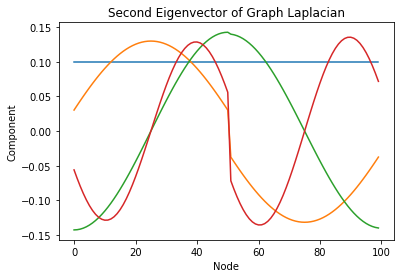

In [18]:
evals, evecs = np.linalg.eigh(laplacian)
plt.title("Second Eigenvector of Graph Laplacian")
plt.xlabel("Node")
plt.ylabel("Component")
plt.plot(evecs[:, :4])
plt.show()

# Differential Basis

Idea: by evolving a differential equation in time from random initial conditions, we can use the solution and a Gram Schmidt orthogonalization process to extract a basis from the time evolved system. For homoegenous diffusion, this basis corresponds to the natural eignebasis induced by the differential operator. What happens if we simulate other PDEs or inhomogenous diffusion?

We must assume the first eigenvector is the constant one

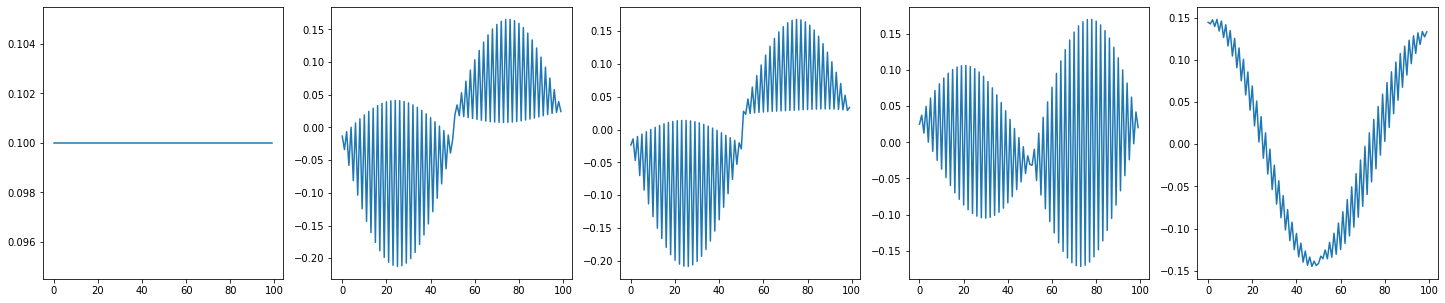

In [19]:
def heat(u_t, graph_laplacian):
    return graph_laplacian @ u_t.reshape((-1, 1))

def forward_euler(initial_condition, compute_dt, dt_scale = 0.1, steps=10000):
    '''
    Simulate a discrete system by evolving it in time according to a given update rule.
    
    Arguments:
        initial_condition (np.ndarray): an (n,) or (n,1) array of initial conditions
        compute_dt (np.ndarray): a vector function (n,1) -> (n,1) which computes the time derivative of the system  
        rel_dt (float): use time steps dt = (rel_dt) * 1/2 dx**2 as prescribed by CFL conditions, where dx=1/n.
        steps (int): simulate a given number of time steps
    
    Returns:
        evolution (np.ndarray): a matrix (n, steps) of the system state at each time step
    '''
    n = initial_condition.shape[0]
    dx = 1/n
    dt = rel_dt * (1/2) * (dx)**2
    initial_condition = initial_condition.reshape((-1, 1))
    
    evolution = np.zeros((n, steps))
    
    for i in range(steps):
        evolution[:, i:i+1] = evolution[:, i-1:i] + update_rule(evolution[:, i-1:i])
    return evolution

def differential_basis(sys_time_evolution, num_vecs):
    '''
    Given the time evolution matrix of a system, compute the associated basis and save visualizations
    
    
    Arguments:
        evolution (np.ndarray): a matrix (n, steps) of the system state at each time step
        num_vecs (int): number of output vectors to compute
    '''
    n, T = sys_time_evolution.shape
    
    def ortho_complement_proj(basis, vec):
        '''Project vec onto the orthogonal complement of columns of basis'''
        vec = vec.reshape((-1, 1))
        basis = basis / np.linalg.norm(basis, axis=0)
        projection = basis @ (basis.T @ vec)
        return vec - projection
    
    basis = np.ones((n, 1)) / np.sqrt(n)
    for i in range(1, num_vecs):
        residual = ortho_complement_proj(basis, sys_time_evolution[:, -(3*i)])
        basis = np.hstack((basis, residual / np.linalg.norm(residual)))
    return basis
    
k = 5
basis = differential_basis(evolution, k)
for i in range(k):
    plt.subplot(1, k, i+1)
    plt.plot(basis[:, i])
plt.gcf().set_size_inches(25, 5)
plt.show()

# Classification Using Fourier Spectrum

For points in cluster 1, cluster 2, plot their frequency spectrum over time 

Want to see: distinguishable difference between the real part

In [20]:
@gif.frame
def plot_frequency_comp(i, left_node, right_node, low_freq=1, high_freq=100):
    def subplot(j):
        plt.subplot(1, 2, j)
        plt.plot(np.real(np.fft.rfft(evolution[left_node, 0:i])[low_freq:high_freq]))
        plt.title(f"Cluster {j}")
        plt.xlabel("Frequency")
        plt.ylabel("Real Coefficient")
    subplot(1)
    subplot(2)
    plt.gcf().set_size_inches((10, 5))
left_node = h-10
right_node = h+10
frames = []
for i in range(1, T_max, 1000):
    frames.append(plot_frequency_comp(int(i), left_node, right_node))
gif.save(frames, "Frequency_per_Cluster.gif", duration=200)